In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from scipy.stats import skew
from sklearn.linear_model import Ridge
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv(
    "C:/Users/sudan/Downloads/house-prices-advanced-regression-techniques/train.csv"
)
test_df = pd.read_csv(
    "C:/Users/sudan/Downloads/house-prices-advanced-regression-techniques/test.csv"
)

train_ID = train_df['Id']
test_ID = test_df['Id']
train_df.drop("Id", axis=1, inplace=True)
test_df.drop("Id", axis=1, inplace=True)

In [3]:
print(f"Number of training examples: {len(train_df)}")
print(f"Number of testing examples: {len(test_df)}")

print(f"Shape of train data: {train_df.shape}")
print(f"Shape of test data: {test_df.shape}")

columns = list(test_df.columns)
target_col = set(train_df.columns) - set(test_df.columns)
print(f"Features:\n{columns}\n")
print(f"Target:\n{target_col}")

full_df = pd.concat([train_df, test_df], axis=0)
full_df.shape

full_df.head()

Number of training examples: 1460
Number of testing examples: 1459
Shape of train data: (1460, 80)
Shape of test data: (1459, 79)
Features:
['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'G

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   
3          70       RL         60.0     9550   Pave   NaN      IR1   
4          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
0         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
1         Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
2         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
3         Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   
4         Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
0       0      2    2008        WD         Normal   208500.0  
1       0      5    2007        WD         Normal   181500.0  
2       0      9    2008        WD         Normal   223500.0  
3       0      2    2006        WD        Abnorml   140000.0  
4       0     12    2008        WD         Normal   250000.0  

[5 rows x 80 columns]

In [4]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuilt    

In [5]:
numeric_df = full_df.select_dtypes(include='number')
object_df = full_df.select_dtypes(include='object')

In [6]:
numeric_df.describe()

MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond  \
count  2919.000000  2433.000000    2919.000000  2919.000000  2919.000000   
mean     57.137718    69.305795   10168.114080     6.089072     5.564577   
std      42.517628    23.344905    7886.996359     1.409947     1.113131   
min      20.000000    21.000000    1300.000000     1.000000     1.000000   
25%      20.000000    59.000000    7478.000000     5.000000     5.000000   
50%      50.000000    68.000000    9453.000000     6.000000     5.000000   
75%      70.000000    80.000000   11570.000000     7.000000     6.000000   
max     190.000000   313.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2  ...  \
count  2919.000000   2919.000000  2896.000000  2918.000000  2918.000000  ...   
mean   1971.312778   1984.264474   102.201312   441.423235    49.582248  ...   
std      30.291442     20.894344   179.334253   455.610826   169.205611  ...   
min    1872.000000   1950.000000     0.000000     0.000000     0.000000  ...   
25%    1953.500000   1965.000000     0.000000     0.000000     0.000000  ...   
50%    1973.000000   1993.000000     0.000000   368.500000     0.000000  ...   
75%    2001.000000   2004.000000   164.000000   733.000000     0.000000  ...   
max    2010.000000   2010.000000  1600.000000  5644.000000  1526.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  2919.000000  2919.000000    2919.000000  2919.000000  2919.000000   
mean     93.709832    47.486811      23.098321     2.602261    16.062350   
std     126.526589    67.575493      64.244246    25.188169    56.184365   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    26.000000       0.000000     0.000000     0.000000   
75%     168.000000    70.000000       0.000000     0.000000     0.000000   
max    1424.000000   742.000000    1012.000000   508.000000   576.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  2919.000000   2919.000000  2919.000000  2919.000000    1460.000000  
mean      2.251799     50.825968     6.213087  2007.792737  180921.195890  
std      35.663946    567.402211     2.714762     1.314964   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     4.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     800.000000  17000.000000    12.000000  2010.000000  755000.000000  

[8 rows x 37 columns]

In [7]:
object_df.describe()

MSZoning Street Alley LotShape LandContour Utilities LotConfig  \
count      2915   2919   198     2919        2919      2917      2919   
unique        5      2     2        4           4         2         5   
top          RL   Pave  Grvl      Reg         Lvl    AllPub    Inside   
freq       2265   2907   120     1859        2622      2916      2133   

       LandSlope Neighborhood Condition1  ... GarageType GarageFinish  \
count       2919         2919       2919  ...       2762         2760   
unique         3           25          9  ...          6            3   
top          Gtl        NAmes       Norm  ...     Attchd          Unf   
freq        2778          443       2511  ...       1723         1230   

       GarageQual GarageCond PavedDrive PoolQC  Fence MiscFeature SaleType  \
count        2760       2760       2919     10    571         105     2918   
unique          5          5          3      3      4           4        9   
top            TA         TA          Y     Ex  MnPrv        Shed       WD   
freq         2604       2654       2641      4    329          95     2525   

       SaleCondition  
count           2919  
unique             6  
top           Normal  
freq            2402  

[4 rows x 43 columns]

In [8]:
with open('C:/Users/sudan/Downloads/house-prices-advanced-regression-techniques/data_description.txt', 'r') as file:
    for line in file:
        print(line.strip())

MSSubClass: Identifies the type of dwelling involved in the sale.

20	1-STORY 1946 & NEWER ALL STYLES
30	1-STORY 1945 & OLDER
40	1-STORY W/FINISHED ATTIC ALL AGES
45	1-1/2 STORY - UNFINISHED ALL AGES
50	1-1/2 STORY FINISHED ALL AGES
60	2-STORY 1946 & NEWER
70	2-STORY 1945 & OLDER
75	2-1/2 STORY ALL AGES
80	SPLIT OR MULTI-LEVEL
85	SPLIT FOYER
90	DUPLEX - ALL STYLES AND AGES
120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
150	1-1/2 STORY PUD - ALL AGES
160	2-STORY PUD - 1946 & NEWER
180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.

A	Agriculture
C	Commercial
FV	Floating Village Residential
I	Industrial
RH	Residential High Density
RL	Residential Low Density
RP	Residential Low Density Park
RM	Residential Medium Density

LotFrontage: Linear feet of street connected to property

LotArea: Lot size in square feet

Street: Type of road access to property

Grvl	Gravel
Pave	Pave

array([[<Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>,
        <Axes: title={'center': 'YearBuilt'}>],
       [<Axes: title={'center': 'YearRemodAdd'}>,
        <Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>,
        <Axes: title={'center': 'TotalBsmtSF'}>],
       [<Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtFullBath'}>,
        <Axes: title={'center': 'BsmtHalfBath'}>],
       [<Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>,
        <Axes: title={'center': 'Bedroo

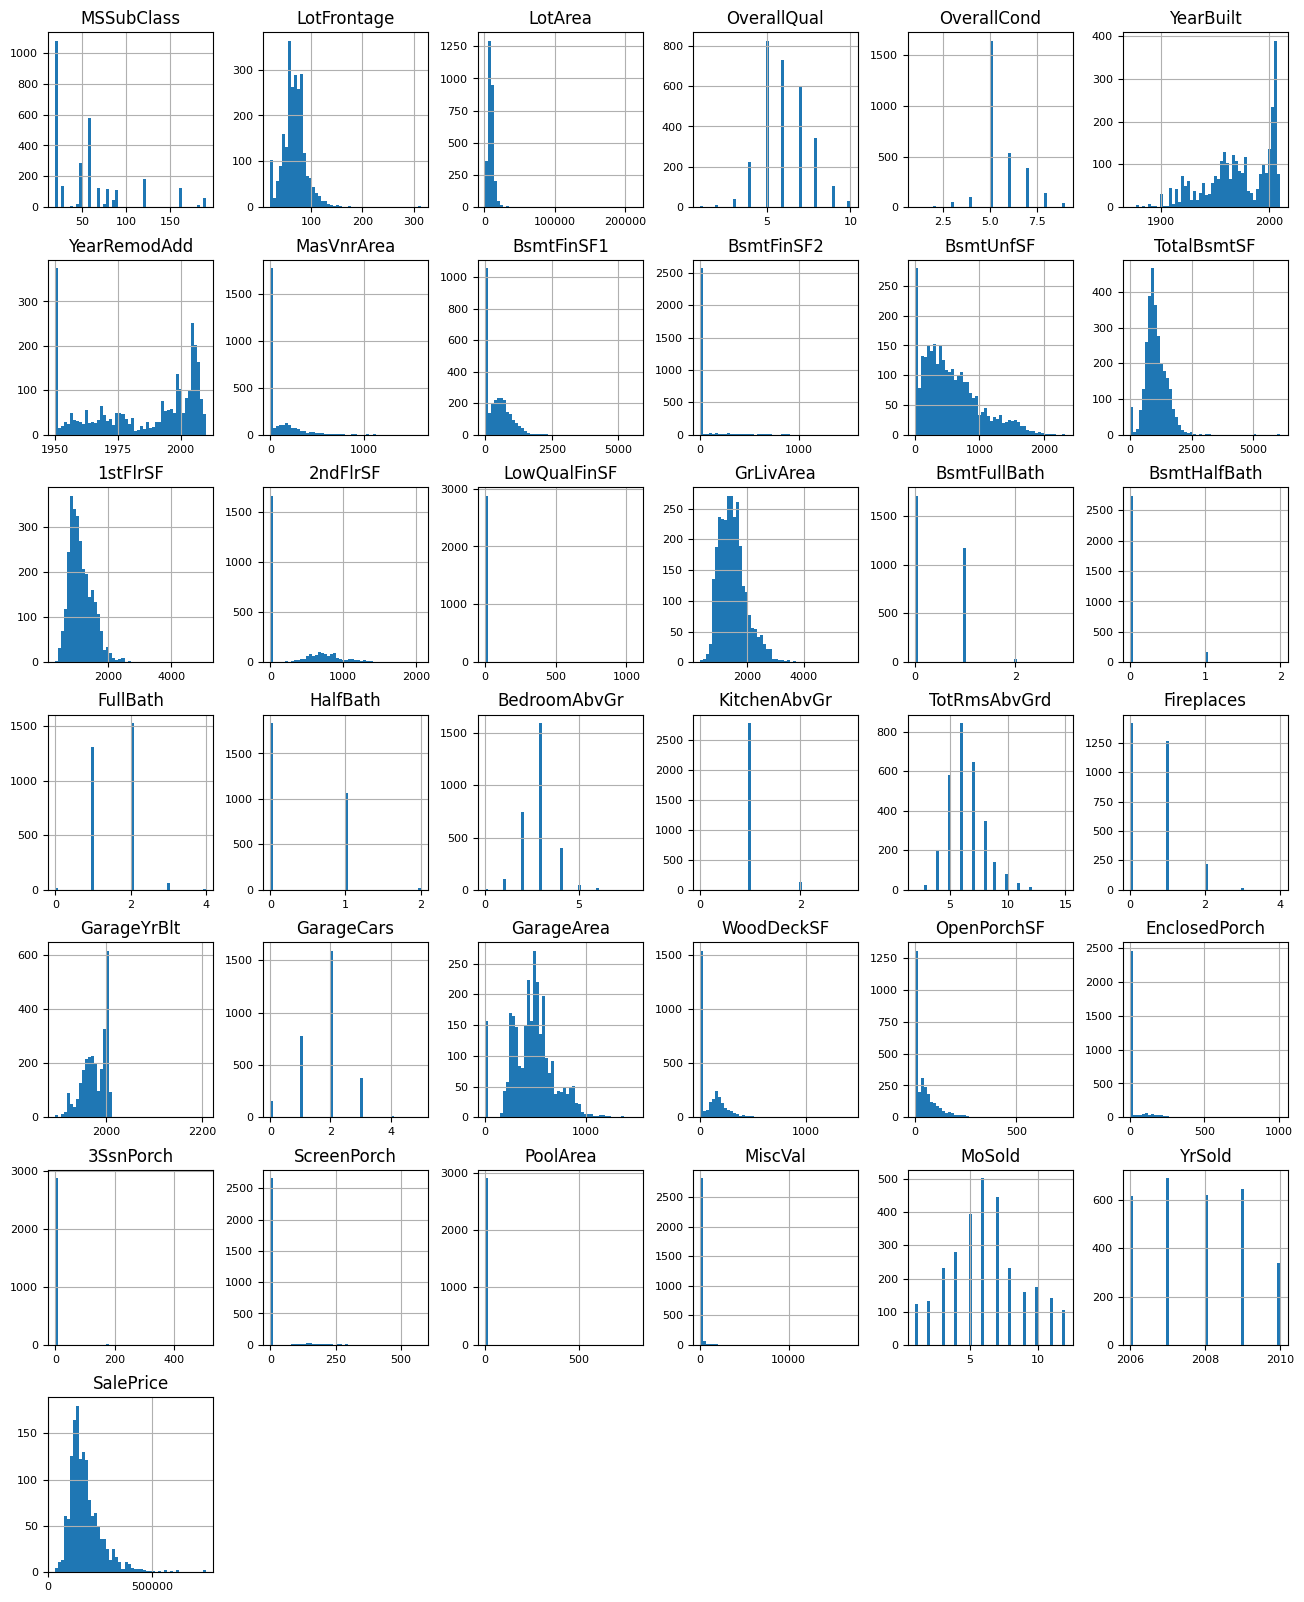

In [9]:
numeric_df.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

In [10]:
from scipy.stats import normaltest



for col in numeric_df.columns:
    stat, p = normaltest(full_df[col].dropna())
    if p > 0.05:
        print(f"{col} looks Gaussian (p={p:.3f})")
    else:
        print(f"{col} is likely NOT Gaussian (p={p:.3f})")

MSSubClass is likely NOT Gaussian (p=0.000)
LotFrontage is likely NOT Gaussian (p=0.000)
LotArea is likely NOT Gaussian (p=0.000)
OverallQual is likely NOT Gaussian (p=0.000)
OverallCond is likely NOT Gaussian (p=0.000)
YearBuilt is likely NOT Gaussian (p=0.000)
YearRemodAdd is likely NOT Gaussian (p=0.000)
MasVnrArea is likely NOT Gaussian (p=0.000)
BsmtFinSF1 is likely NOT Gaussian (p=0.000)
BsmtFinSF2 is likely NOT Gaussian (p=0.000)
BsmtUnfSF is likely NOT Gaussian (p=0.000)
TotalBsmtSF is likely NOT Gaussian (p=0.000)
1stFlrSF is likely NOT Gaussian (p=0.000)
2ndFlrSF is likely NOT Gaussian (p=0.000)
LowQualFinSF is likely NOT Gaussian (p=0.000)
GrLivArea is likely NOT Gaussian (p=0.000)
BsmtFullBath is likely NOT Gaussian (p=0.000)
BsmtHalfBath is likely NOT Gaussian (p=0.000)
FullBath is likely NOT Gaussian (p=0.000)
HalfBath is likely NOT Gaussian (p=0.000)
BedroomAbvGr is likely NOT Gaussian (p=0.000)
KitchenAbvGr is likely NOT Gaussian (p=0.000)
TotRmsAbvGrd is likely NOT Gau

In [11]:
skewness = numeric_df.skew().sort_values(ascending=False)

# Filter features with high skewness
high_skew = skewness[abs(skewness) > 0.75]
print("Highly skewed features:")
print(high_skew)

Highly skewed features:
MiscVal          21.958480
PoolArea         16.907017
LotArea          12.829025
LowQualFinSF     12.094977
3SsnPorch        11.381914
KitchenAbvGr      4.304467
BsmtFinSF2        4.147456
EnclosedPorch     4.005950
ScreenPorch       3.948723
BsmtHalfBath      3.932018
MasVnrArea        2.602589
OpenPorchSF       2.536417
SalePrice         1.882876
WoodDeckSF        1.843380
LotFrontage       1.503278
1stFlrSF          1.470360
BsmtFinSF1        1.425722
MSSubClass        1.376165
GrLivArea         1.270010
TotalBsmtSF       1.162882
BsmtUnfSF         0.919824
2ndFlrSF          0.862118
TotRmsAbvGrd      0.758757
dtype: float64


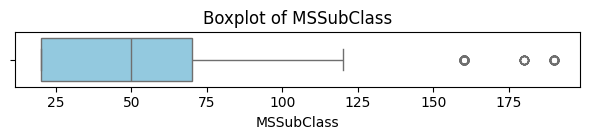

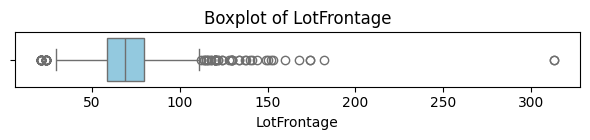

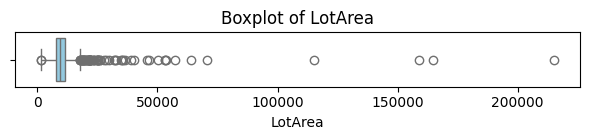

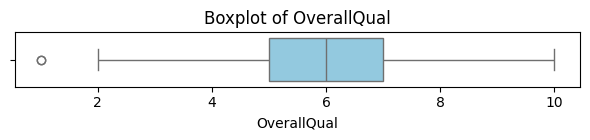

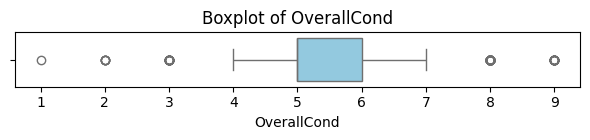

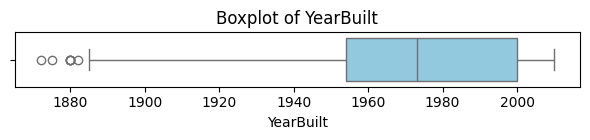

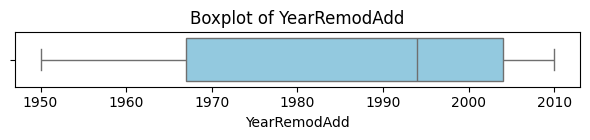

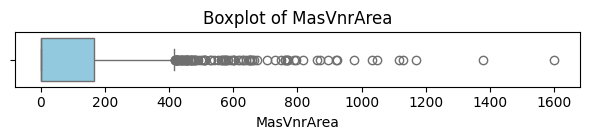

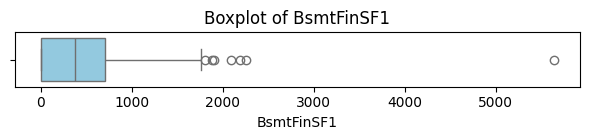

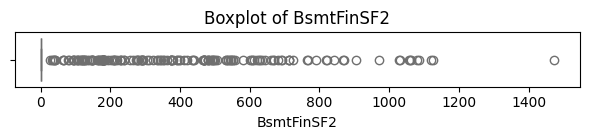

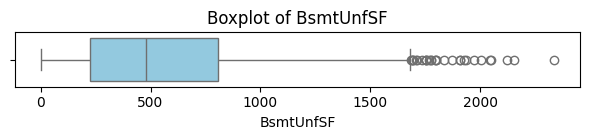

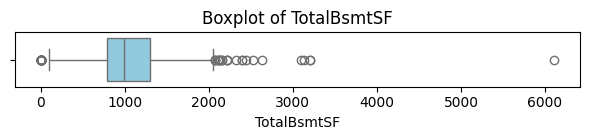

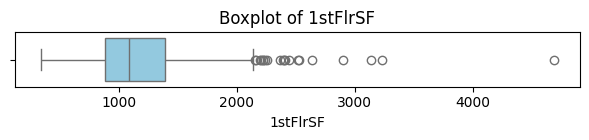

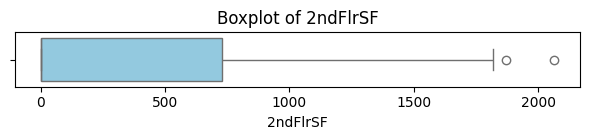

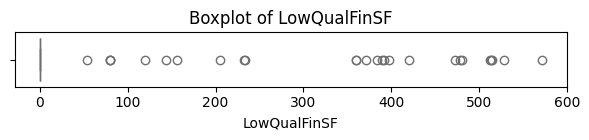

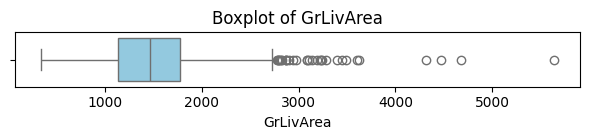

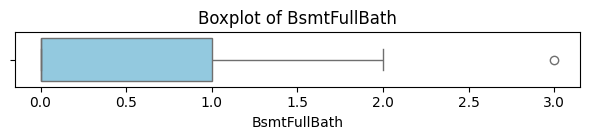

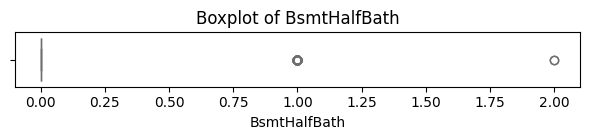

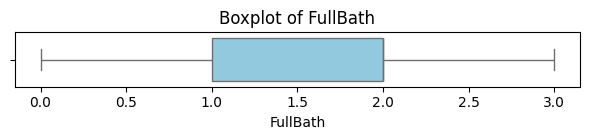

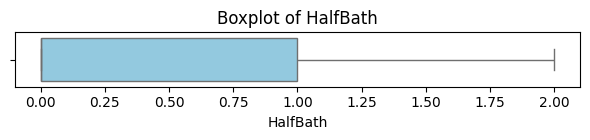

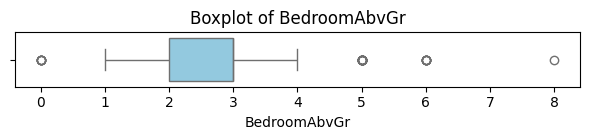

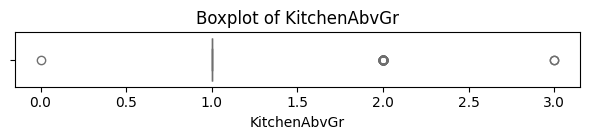

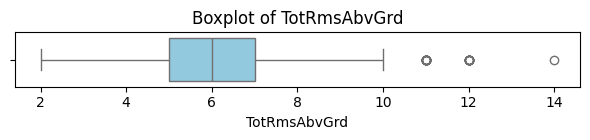

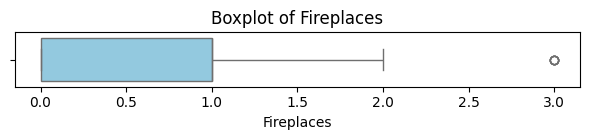

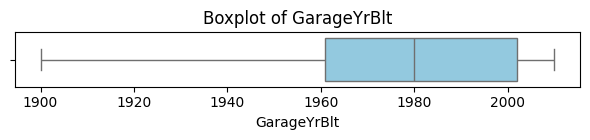

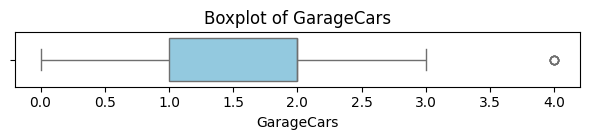

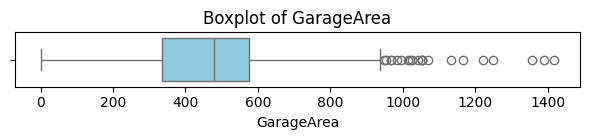

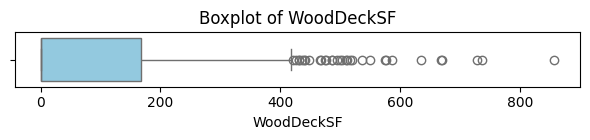

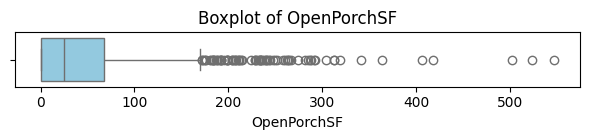

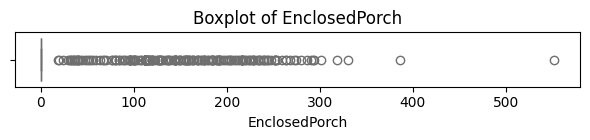

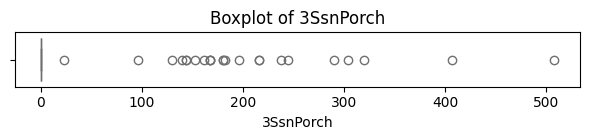

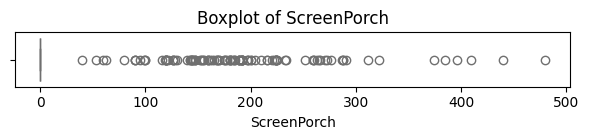

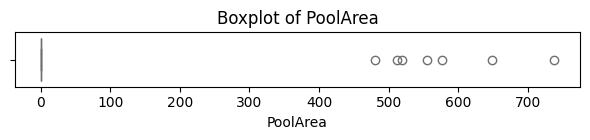

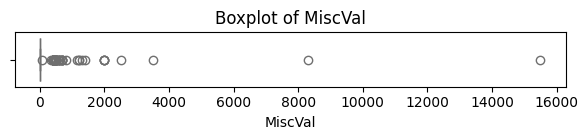

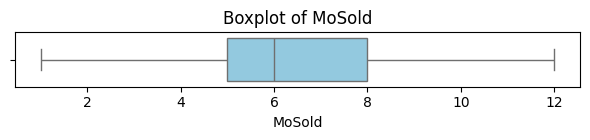

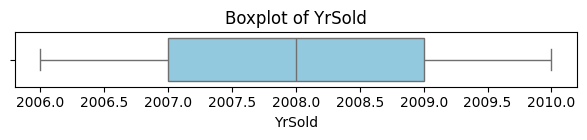

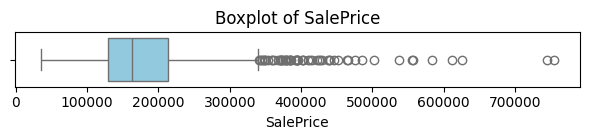

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = numeric_df.select_dtypes(include=['int64', 'float64']).columns


for col in numeric_cols:
    plt.figure(figsize=(6, 1.5))
    sns.boxplot(x=numeric_df[col], color="skyblue")
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

In [15]:
# Check for duplicate column names
print(numeric_df.columns.duplicated().any())  # Should be False

# Check for duplicate index values
print(numeric_df.index.duplicated().any())  # Should be False


False
False


In [14]:
# Remove duplicate index entries (keep first occurrence)
numeric_df = numeric_df[~numeric_df.index.duplicated()]

In [17]:
na_columns = full_df.isna().sum()[full_df.isna().sum() > (0.1 * len(full_df))]
print(f"NA values:\n\n{na_columns}\n==================================\n")
print(f"Percentage of NA values above 10% of the data:\n\n{na_columns / len(full_df)}")

NA values:

LotFrontage     486
Alley          2721
MasVnrType     1766
FireplaceQu    1420
PoolQC         2909
Fence          2348
MiscFeature    2814
SalePrice      1459
dtype: int64

Percentage of NA values above 10% of the data:

LotFrontage    0.166495
Alley          0.932169
MasVnrType     0.605002
FireplaceQu    0.486468
PoolQC         0.996574
Fence          0.804385
MiscFeature    0.964029
SalePrice      0.499829
dtype: float64


Index(['LotFrontage', 'Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')


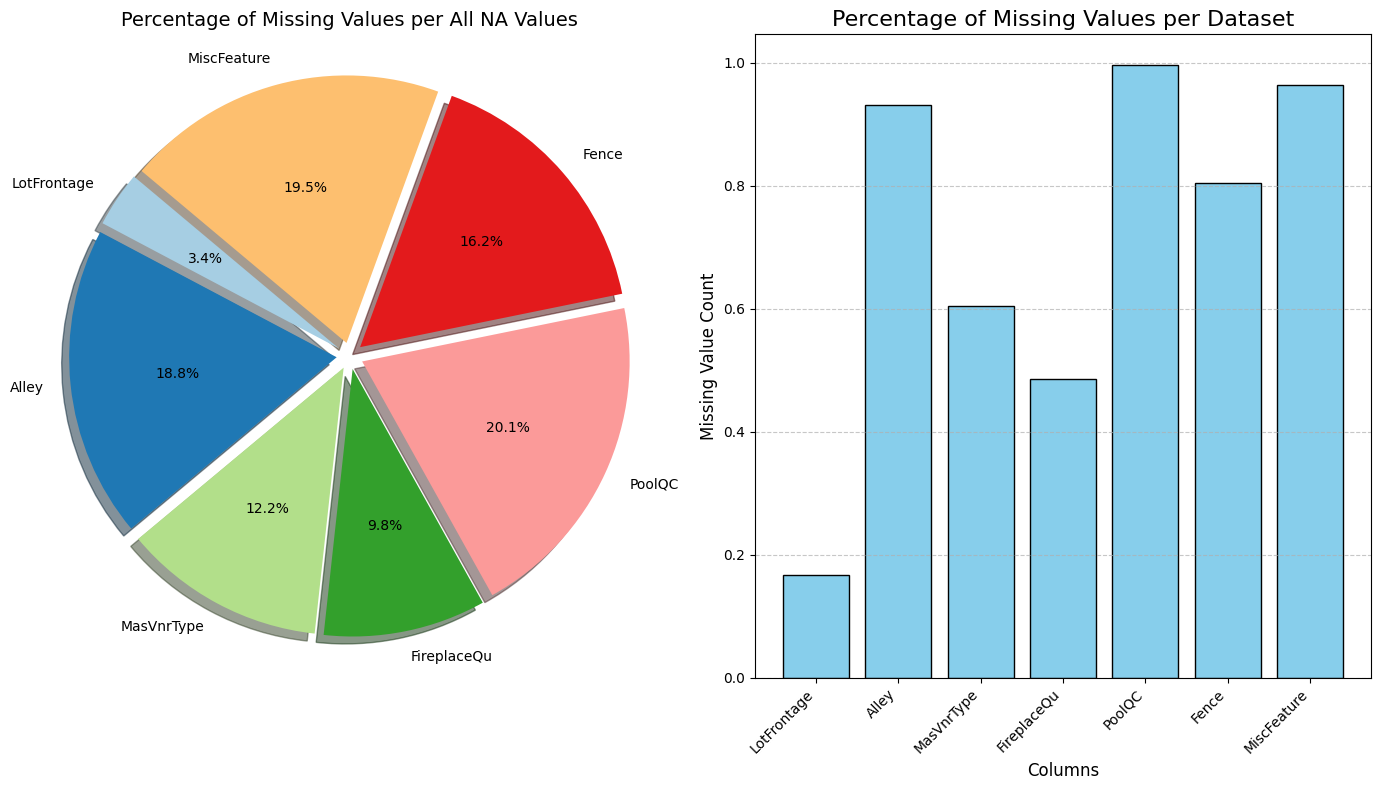

In [18]:
import matplotlib.pyplot as plt

values = na_columns.drop(["SalePrice"]).values
labels = na_columns.drop(["SalePrice"]).index
print(labels)
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.pie(
    values,
    labels=labels,
    autopct='%1.1f%%',         
    startangle=140,            
    shadow=True,              
    explode=[0.05] * len(values),  
    colors=plt.cm.Paired.colors  
)
plt.title('Percentage of Missing Values per All NA Values', fontsize=14)
plt.axis('equal')  

plt.subplot(1, 2, 2)
plt.bar(labels, values / len(full_df), color='skyblue', edgecolor='black')
plt.title('Percentage of Missing Values per Dataset', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Missing Value Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [19]:
for col in na_columns.drop("SalePrice").index[0:]:
    print(full_df[col].value_counts(dropna=False))
    print("="*30)

LotFrontage
NaN      486
60.0     276
80.0     137
70.0     133
50.0     117
        ... 
111.0      1
138.0      1
182.0      1
168.0      1
133.0      1
Name: count, Length: 129, dtype: int64
Alley
NaN     2721
Grvl     120
Pave      78
Name: count, dtype: int64
MasVnrType
NaN        1766
BrkFace     879
Stone       249
BrkCmn       25
Name: count, dtype: int64
FireplaceQu
NaN    1420
Gd      744
TA      592
Fa       74
Po       46
Ex       43
Name: count, dtype: int64
PoolQC
NaN    2909
Ex        4
Gd        4
Fa        2
Name: count, dtype: int64
Fence
NaN      2348
MnPrv     329
GdPrv     118
GdWo      112
MnWw       12
Name: count, dtype: int64
MiscFeature
NaN     2814
Shed      95
Gar2       5
Othr       4
TenC       1
Name: count, dtype: int64


In [20]:
few_na_columns = full_df.isna().sum()[full_df.isna().sum() > 0]
few_na_columns = few_na_columns[full_df.isna().sum() <= 0.1 * len(full_df)]
few_na_columns

MSZoning          4
Utilities         2
Exterior1st       1
Exterior2nd       1
MasVnrArea       23
BsmtQual         81
BsmtCond         82
BsmtExposure     82
BsmtFinType1     79
BsmtFinSF1        1
BsmtFinType2     80
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
Electrical        1
BsmtFullBath      2
BsmtHalfBath      2
KitchenQual       1
Functional        2
GarageType      157
GarageYrBlt     159
GarageFinish    159
GarageCars        1
GarageArea        1
GarageQual      159
GarageCond      159
SaleType          1
dtype: int64

In [21]:
for col in few_na_columns.index:
    print(full_df[col].value_counts(dropna=False))
    print("="*30)

MSZoning
RL         2265
RM          460
FV          139
RH           26
C (all)      25
NaN           4
Name: count, dtype: int64
Utilities
AllPub    2916
NaN          2
NoSeWa       1
Name: count, dtype: int64
Exterior1st
VinylSd    1025
MetalSd     450
HdBoard     442
Wd Sdng     411
Plywood     221
CemntBd     126
BrkFace      87
WdShing      56
AsbShng      44
Stucco       43
BrkComm       6
AsphShn       2
Stone         2
CBlock        2
ImStucc       1
NaN           1
Name: count, dtype: int64
Exterior2nd
VinylSd    1014
MetalSd     447
HdBoard     406
Wd Sdng     391
Plywood     270
CmentBd     126
Wd Shng      81
Stucco       47
BrkFace      47
AsbShng      38
Brk Cmn      22
ImStucc      15
Stone         6
AsphShn       4
CBlock        3
Other         1
NaN           1
Name: count, dtype: int64
MasVnrArea
0.0      1738
NaN        23
120.0      15
176.0      13
200.0      13
         ... 
788.0       1
796.0       1
391.0       1
604.0       1
382.0       1
Name: count, Length

In [22]:
train_clean = train_df.copy()
test_clean = test_df.copy()

In [23]:
cols_to_drop = [ "Alley", "PoolQC", "Fence", "MiscFeature", "Utilities"]
train_clean = train_clean.drop(cols_to_drop, axis=1)
test_clean = test_clean.drop(cols_to_drop, axis=1)

In [24]:
median_lotfrontage = train_clean["LotFrontage"].median()
train_clean["LotFrontage"] = train_clean["LotFrontage"].fillna(median_lotfrontage)
test_clean["LotFrontage"] = test_clean["LotFrontage"].fillna(median_lotfrontage)

In [25]:
train_clean["MasVnrType"] = train_clean["MasVnrType"].fillna("None")
test_clean["MasVnrType"] = test_clean["MasVnrType"].fillna("None")
train_clean["MasVnrType"].value_counts(dropna=False)

MasVnrType
None       872
BrkFace    445
Stone      128
BrkCmn      15
Name: count, dtype: int64

In [26]:
cols_to_NA_category = ["FireplaceQu", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
                       "BsmtFinType2", "GarageType", "GarageFinish", "GarageQual", "GarageCond"]

for col in cols_to_NA_category:
    train_clean[col] = train_clean[col].fillna("NA")
    test_clean[col] = test_clean[col].fillna("NA")

    print(train_clean[col].value_counts(dropna=False))
    print("="*30)

FireplaceQu
NA    690
Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: count, dtype: int64
BsmtQual
TA    649
Gd    618
Ex    121
NA     37
Fa     35
Name: count, dtype: int64
BsmtCond
TA    1311
Gd      65
Fa      45
NA      37
Po       2
Name: count, dtype: int64
BsmtExposure
No    953
Av    221
Gd    134
Mn    114
NA     38
Name: count, dtype: int64
BsmtFinType1
Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
NA      37
Name: count, dtype: int64
BsmtFinType2
Unf    1256
Rec      54
LwQ      46
NA       38
BLQ      33
ALQ      19
GLQ      14
Name: count, dtype: int64
GarageType
Attchd     870
Detchd     387
BuiltIn     88
NA          81
Basment     19
CarPort      9
2Types       6
Name: count, dtype: int64
GarageFinish
Unf    605
RFn    422
Fin    352
NA      81
Name: count, dtype: int64
GarageQual
TA    1311
NA      81
Fa      48
Gd      14
Ex       3
Po       3
Name: count, dtype: int64
GarageCond
TA    1326
NA      81
Fa      35
Gd       9
Po       7
Ex   

In [27]:
cols_to_zero = ["MasVnrArea", "TotalBsmtSF", "BsmtFinSF1","BsmtHalfBath",
                "BsmtFinSF2", "BsmtUnfSF","BsmtFullBath","GarageCars", "GarageArea","GarageYrBlt"]

for col in cols_to_zero:
    train_clean[col] = train_clean[col].fillna(0)
    test_clean[col] = test_clean[col].fillna(0)

    print(train_clean[col].value_counts(dropna=False))
    print("="*30)

MasVnrArea
0.0      869
180.0      8
72.0       8
108.0      8
120.0      7
        ... 
562.0      1
89.0       1
921.0      1
762.0      1
119.0      1
Name: count, Length: 327, dtype: int64
TotalBsmtSF
0       37
864     35
672     17
912     15
1040    14
        ..
1838     1
1581     1
707      1
611      1
1542     1
Name: count, Length: 721, dtype: int64
BsmtFinSF1
0       467
24       12
16        9
686       5
662       5
       ... 
1338      1
1324      1
1460      1
328       1
830       1
Name: count, Length: 637, dtype: int64
BsmtHalfBath
0    1378
1      80
2       2
Name: count, dtype: int64
BsmtFinSF2
0       1293
180        5
374        3
551        2
147        2
        ... 
532        1
165        1
1120       1
311        1
1029       1
Name: count, Length: 144, dtype: int64
BsmtUnfSF
0       118
728       9
384       8
600       7
300       7
       ... 
551       1
1257      1
605       1
467       1
136       1
Name: count, Length: 780, dtype: int64
BsmtFullBa

In [28]:
cols_to_mode = ["MSZoning", "Exterior1st", "Exterior2nd", "Electrical", 
                "KitchenQual", "Functional",  "SaleType"]

for col in cols_to_mode:
    mode = train_clean[col].mode()
    train_clean[col] = train_clean[col].fillna(mode[0])
    test_clean[col] = test_clean[col].fillna(mode[0])

    print(train_clean[col].value_counts(dropna=False))
    print("="*30)

MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64
Exterior1st
VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
BrkComm      2
Stone        2
AsphShn      1
ImStucc      1
CBlock       1
Name: count, dtype: int64
Exterior2nd
VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
Other        1
CBlock       1
Name: count, dtype: int64
Electrical
SBrkr    1335
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: count, dtype: int64
KitchenQual
TA    735
Gd    586
Ex    100
Fa     39
Name: count, dtype: int64
Functional
Typ     1360
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: count, dtype: int64
SaleType
WD       1267
New     

In [29]:
test_clean.isna().sum()[test_clean.isna().sum()>0]

Series([], dtype: int64)

In [30]:
train_clean.isna().sum()[train_clean.isna().sum()>0]

Series([], dtype: int64)

In [31]:
full_df['TotalBath'] = (full_df['FullBath'] + 0.5 * full_df['HalfBath']
                       + full_df['BsmtFullBath'] + 0.5 * full_df['BsmtHalfBath'])
full_df['TotalSF'] = (full_df['TotalBsmtSF']
                     + full_df['1stFlrSF'] + full_df['2ndFlrSF'])
full_df['Age'] = full_df['YrSold']- full_df['YearBuilt']


train_df['TotalBath'] = (train_df['FullBath'] + 0.5 * train_df['HalfBath']
                       + train_df['BsmtFullBath'] + 0.5 * train_df['BsmtHalfBath'])
train_df['TotalSF'] = (train_df['TotalBsmtSF']
                     + train_df['1stFlrSF'] + train_df['2ndFlrSF'])
train_df['Age'] = train_df['YrSold']- train_df['YearBuilt']

test_df['TotalBath'] = (test_df['FullBath'] + 0.5 * test_df['HalfBath']
                       + test_df['BsmtFullBath'] + 0.5 * test_df['BsmtHalfBath'])
test_df['TotalSF'] = (test_df['TotalBsmtSF']
                     + test_df['1stFlrSF'] + test_df['2ndFlrSF'])
test_df['Age'] = test_df['YrSold']- test_df['YearBuilt']

In [32]:
cat_train_df = train_clean.select_dtypes(include="object")
cat_test_df = test_clean.select_dtypes(include="object")

print(f"Train Category Columns: \n{cat_train_df.columns}")
print(f"Test Category Columns: \n{cat_test_df.columns}")

Train Category Columns: 
Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')
Test Category Columns: 
Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'Bsm

In [33]:
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd


cat_cols = train_clean.select_dtypes(include="object").columns


combined_cats = pd.concat([train_clean[cat_cols], test_clean[cat_cols]], axis=0)


ord_enc = OrdinalEncoder(
    handle_unknown='use_encoded_value',
    unknown_value=-1
)


ord_enc.fit(combined_cats)


cat_train_encoded = ord_enc.transform(train_clean[cat_cols])
cat_test_encoded = ord_enc.transform(test_clean[cat_cols])

In [34]:
cat_train_df.shape, cat_train_encoded.shape


((1460, 38), (1460, 38))

In [35]:
num_train_df = train_clean.select_dtypes(include="number")
num_test_df = test_clean.select_dtypes(include="number")

cat_train_encoded = pd.DataFrame(cat_train_encoded, columns=cat_train_df.columns)
train_encoded = pd.concat([num_train_df, cat_train_encoded], axis=1)

cat_test_encoded = pd.DataFrame(cat_test_encoded, columns=cat_train_df.columns)
test_encoded = pd.concat([num_test_df, cat_test_encoded], axis=1)

train_encoded.shape, test_encoded.shape

((1460, 75), (1459, 74))

In [36]:
numeric_cols = test_encoded.select_dtypes(include=['int64', 'float64']).columns

# 2. Calculate skewness before applying log1p
train_skew_before = train_encoded[numeric_cols].skew()
#test_skew_before = test_encoded[numeric_cols].skew()
# 3. Apply log1p only to columns with all values >= 0
train_log_df = train_encoded[numeric_cols].apply(lambda x: np.log1p(x) if (x >= 0).all() else x)
#test_log_df = test_encoded[numeric_cols].apply(lambda x: np.log1p(x) if (x >= 0).all() else x)
# 4. Calculate skewness after applying log1p
train_skew_after = train_log_df.skew()
#test_skew_after = test_log_df.skew()
# 5. Compare skewness and find columns where log1p improved it
improved_skew = (abs(train_skew_after) < abs(train_skew_before))
train_better_columns = train_skew_after[improved_skew].index.tolist()

# 6. Print the result
print("Columns where log1p improved skewness:")
print(train_better_columns)

Columns where log1p improved skewness:
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'RoofStyle', 'RoofMatl', 'Heating', 'HeatingQC', 'CentralAir', 'GarageType']


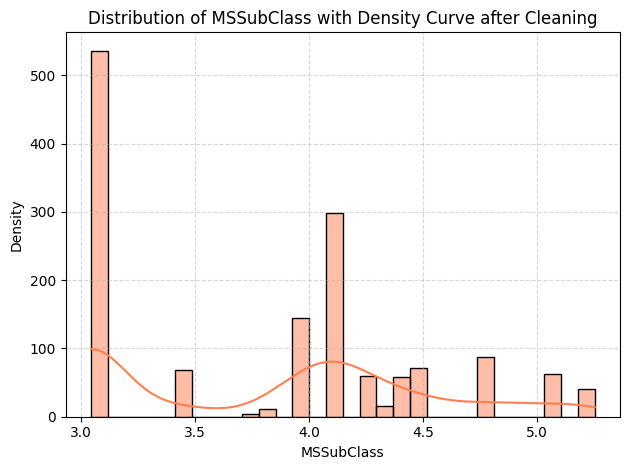

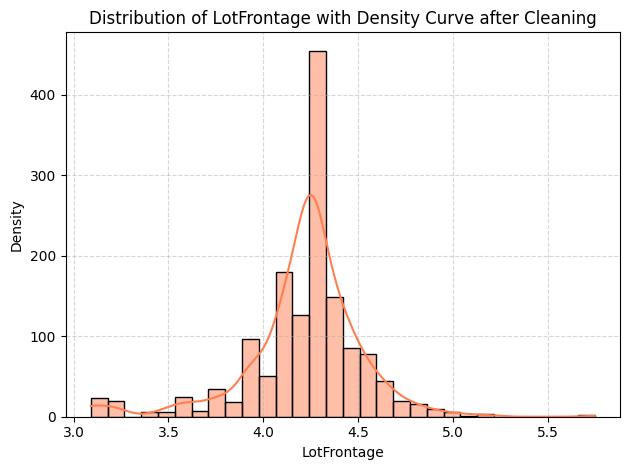

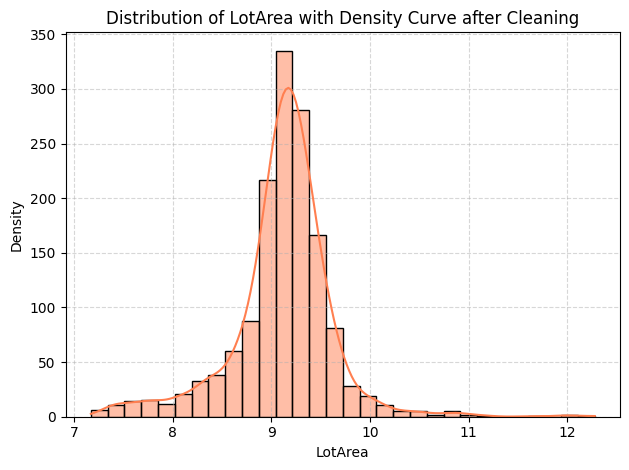

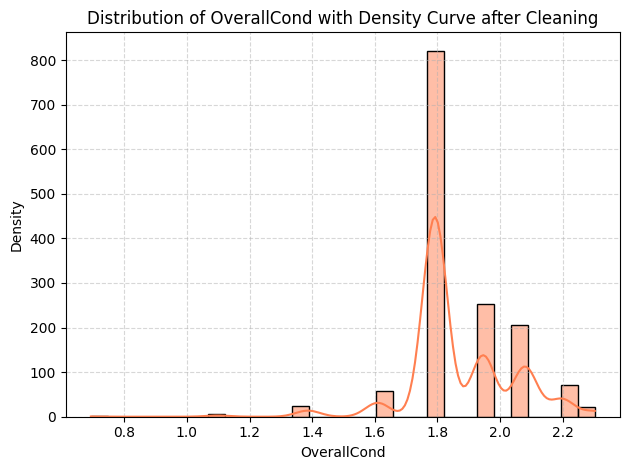

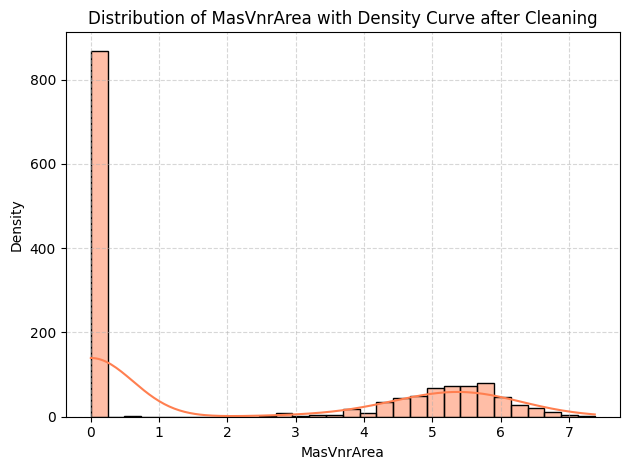

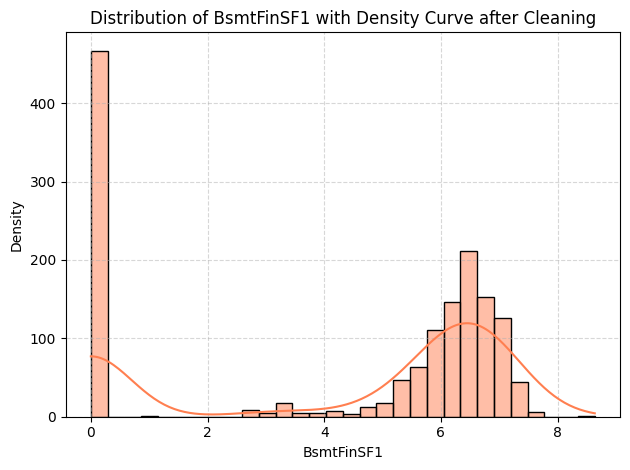

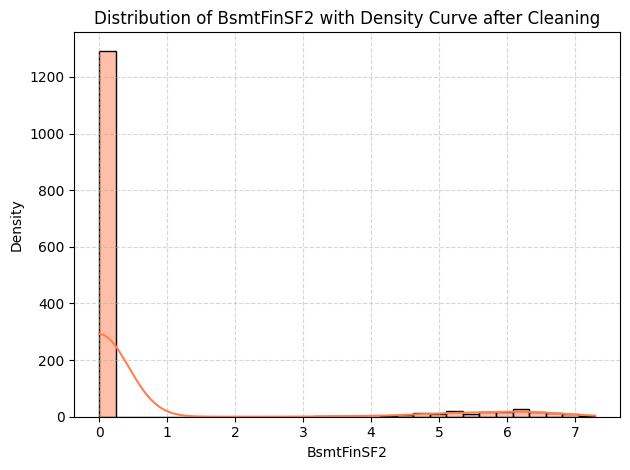

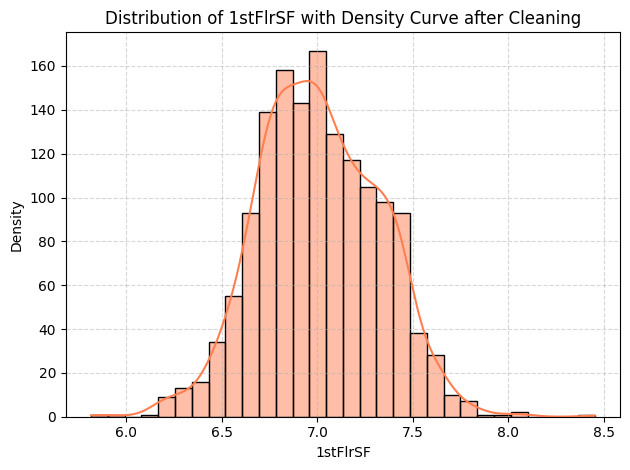

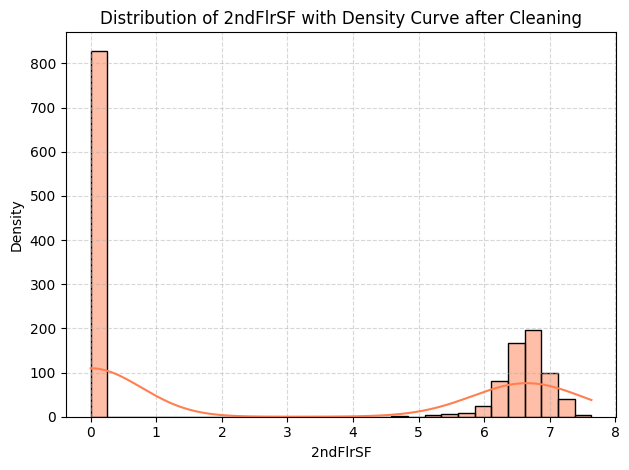

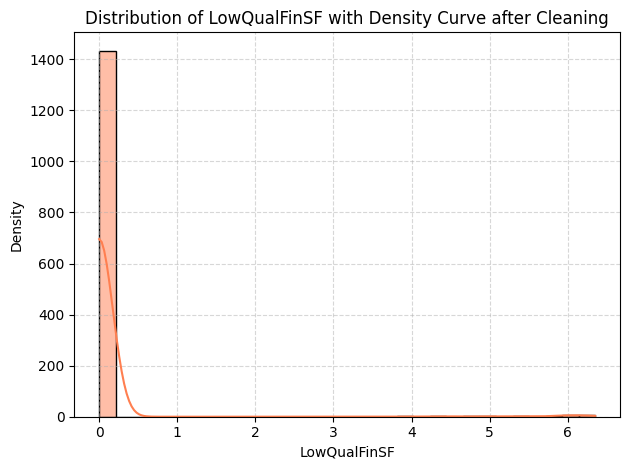

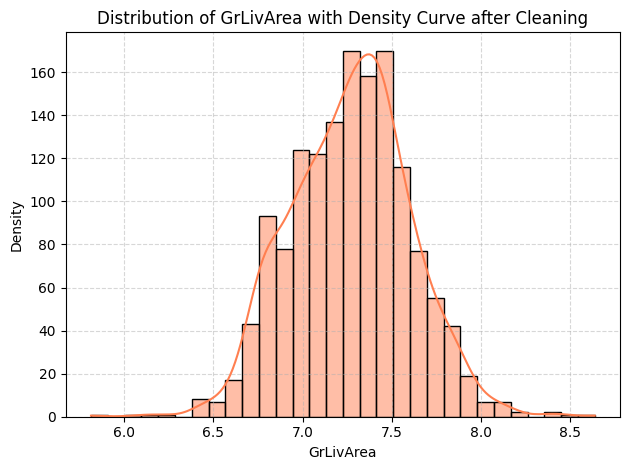

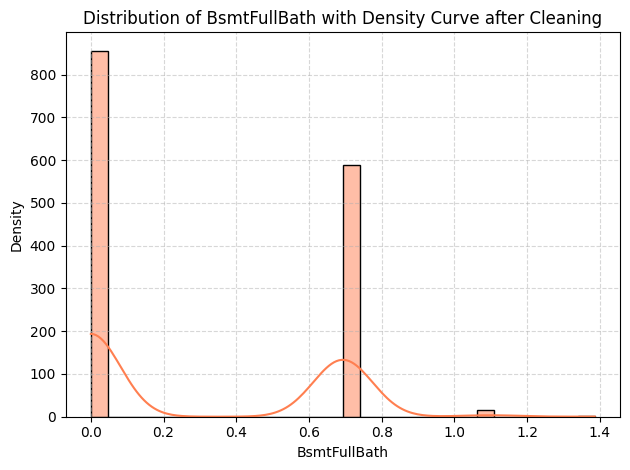

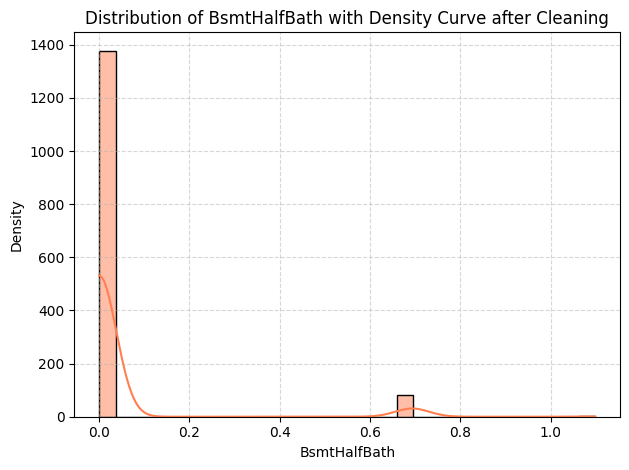

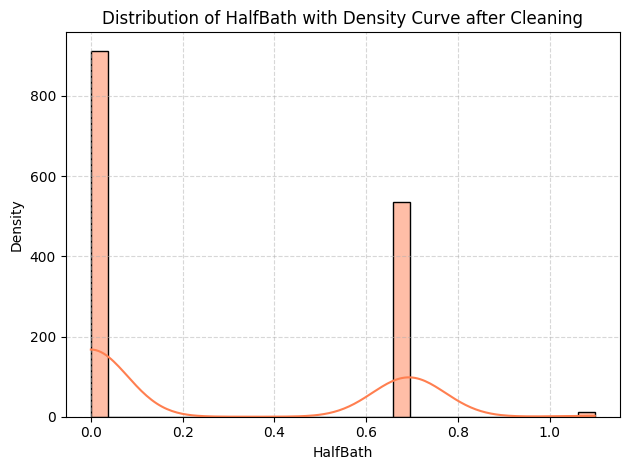

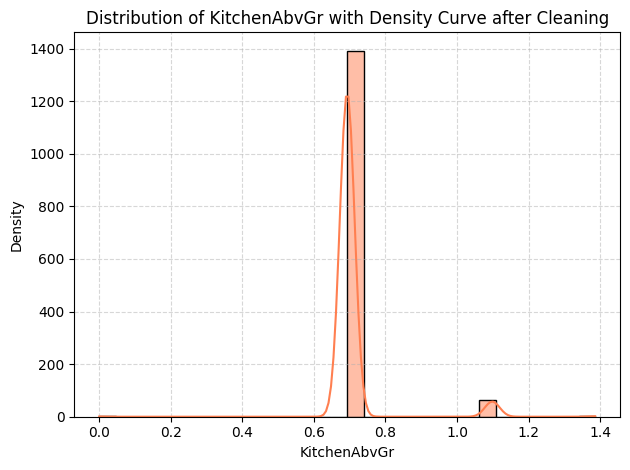

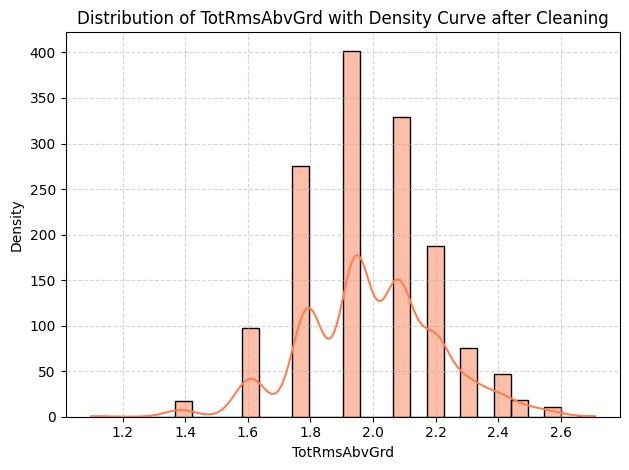

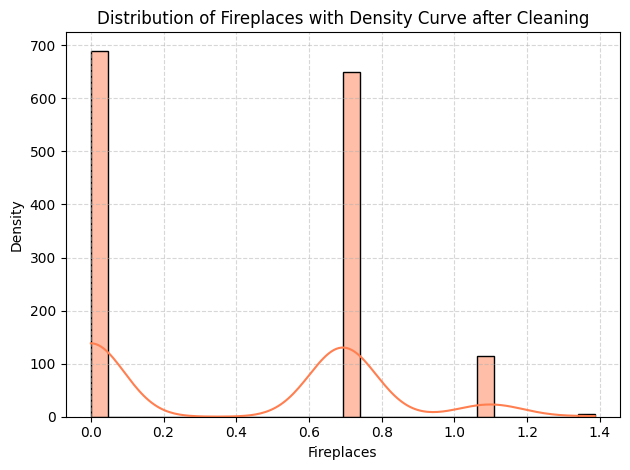

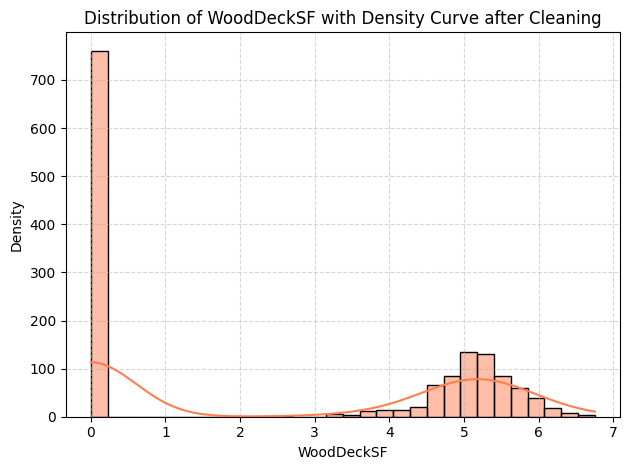

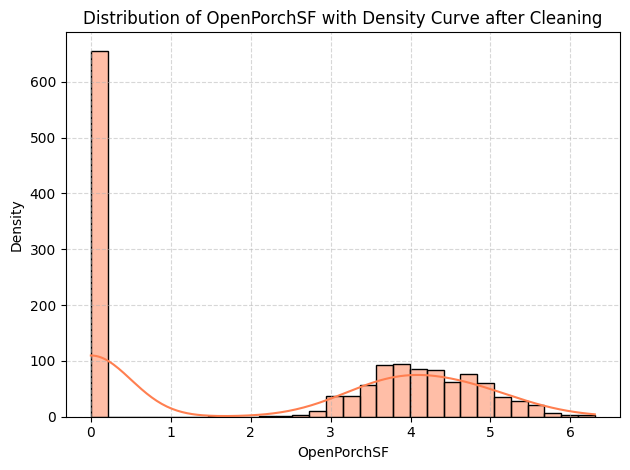

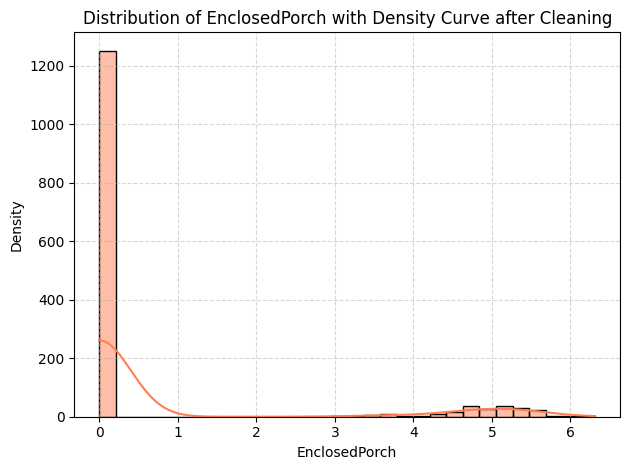

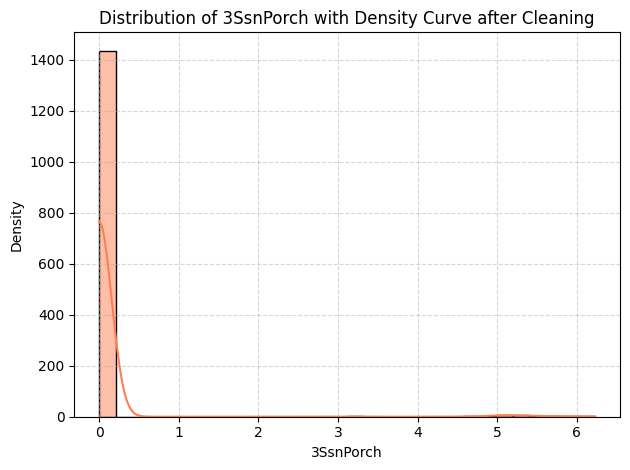

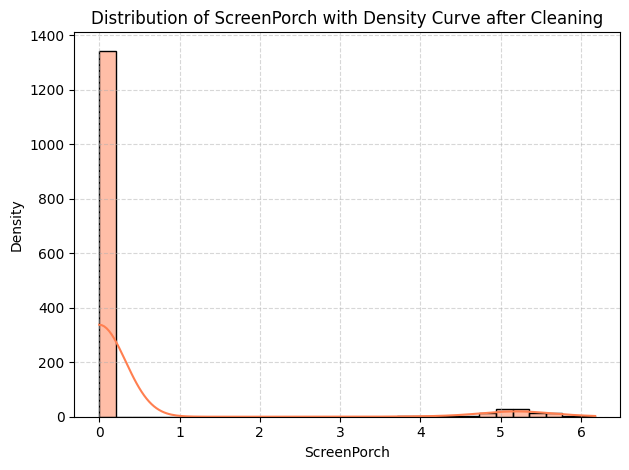

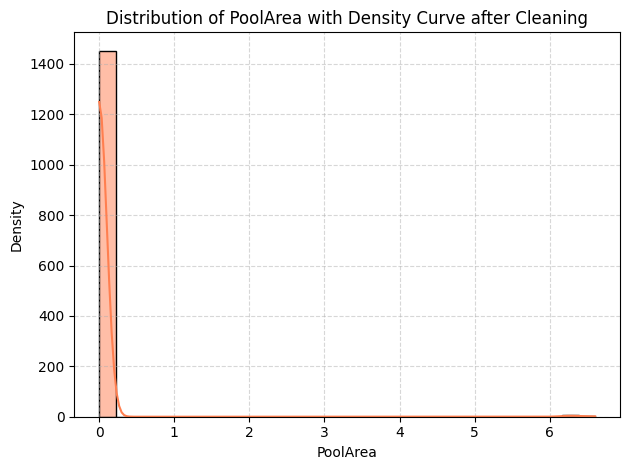

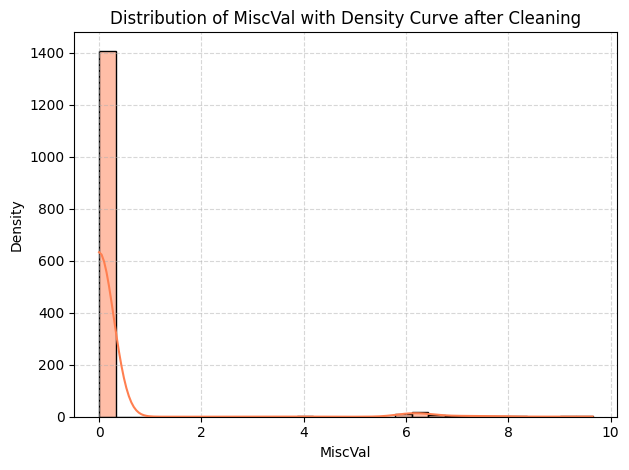

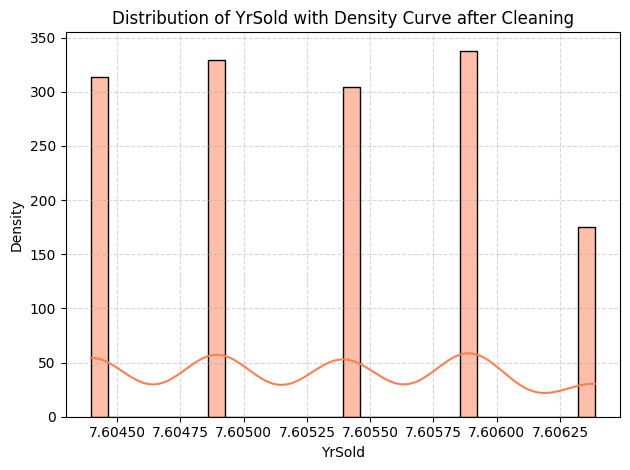

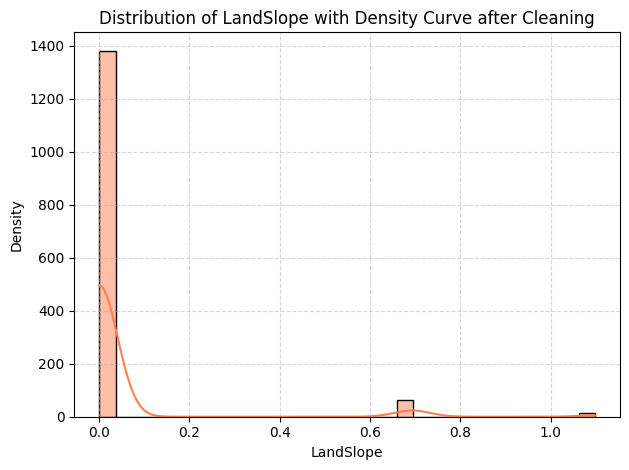

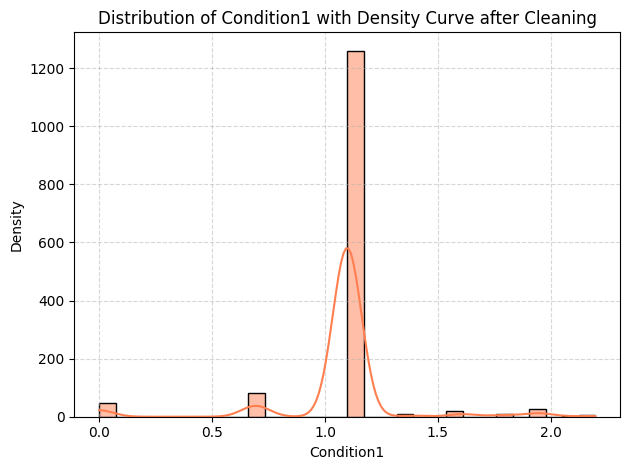

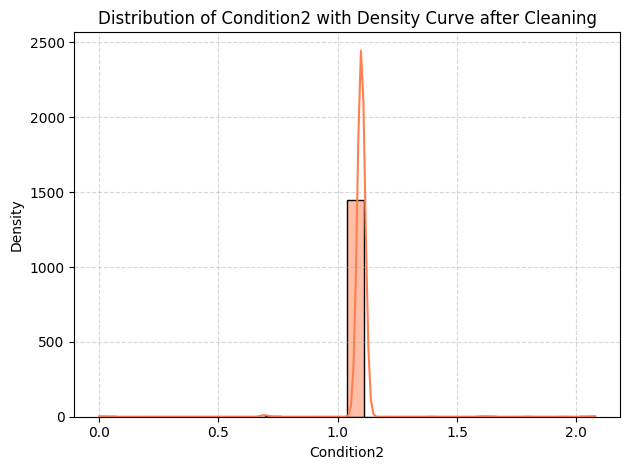

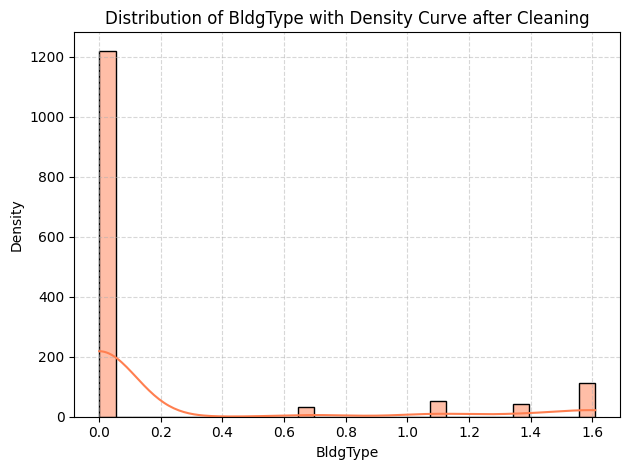

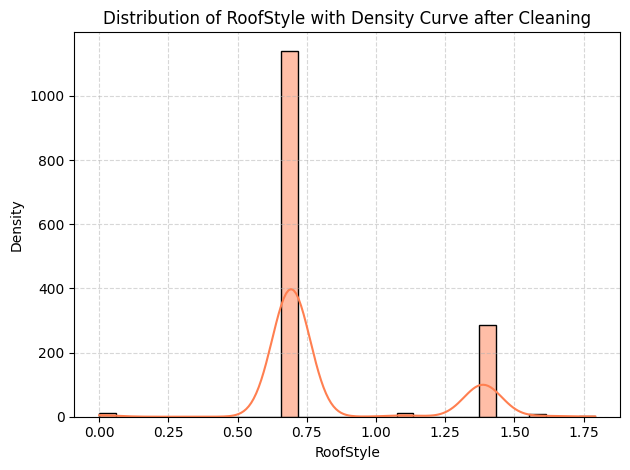

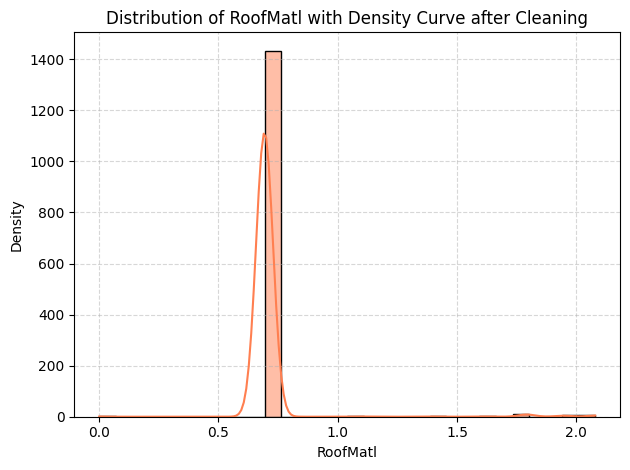

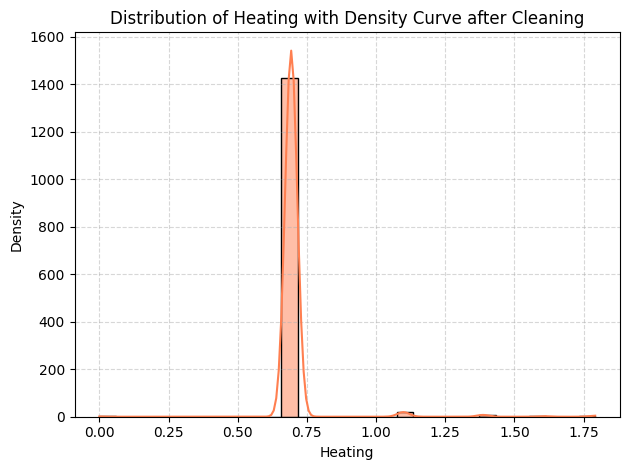

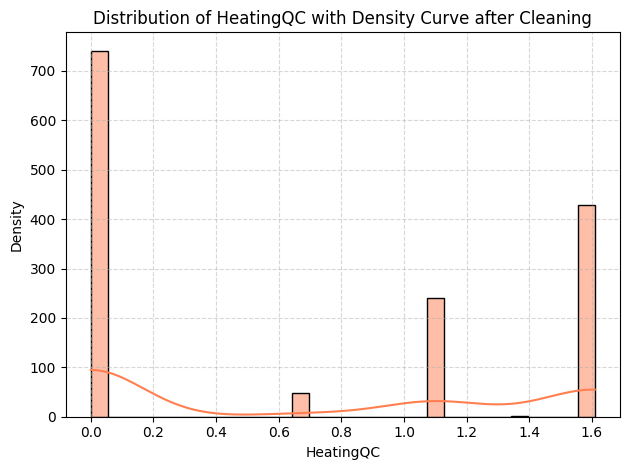

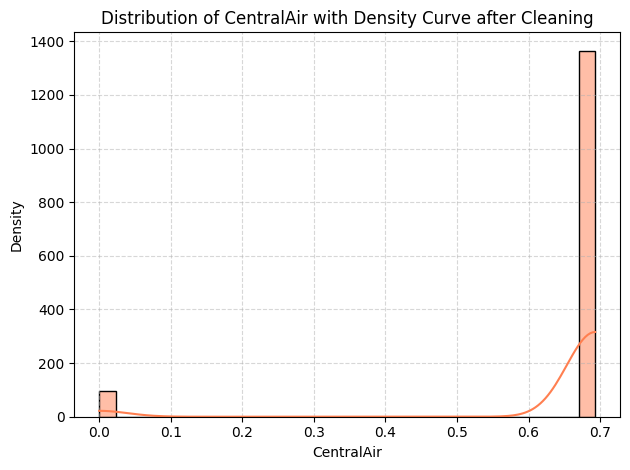

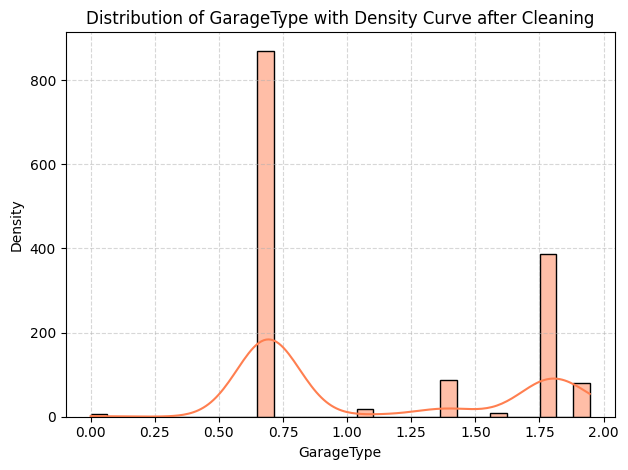

In [37]:
import seaborn as sns

for col in train_better_columns:
    train_encoded[col] =  np.log1p(train_encoded[col])
    test_encoded[col] = np.log1p(test_encoded[col])

    sns.histplot(train_encoded[col], bins=30, kde=True, color="coral")
    plt.title(f"Distribution of {col} with Density Curve after Cleaning")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [38]:
from sklearn.preprocessing import StandardScaler

scaler =  StandardScaler()
scaler.fit(num_train_df.drop("SalePrice", axis=1))
num_train_scaled = scaler.transform(num_train_df.drop("SalePrice", axis=1))
num_test_scaled = scaler.transform(num_test_df)

In [39]:
num_train_transformed = pd.DataFrame(
    num_train_scaled,
    columns=num_train_df.drop(columns=['SalePrice']).columns,
    index=num_train_df.index
)
num_test_transformed = pd.DataFrame(num_test_scaled, columns=num_test_df.columns)

train_transformed = pd.concat([num_train_transformed, num_train_df["SalePrice"], cat_train_encoded], axis=1)
test_transformed = pd.concat([num_test_transformed, cat_test_encoded], axis=1)

train_transformed.shape, test_transformed.shape

((1460, 75), (1459, 74))

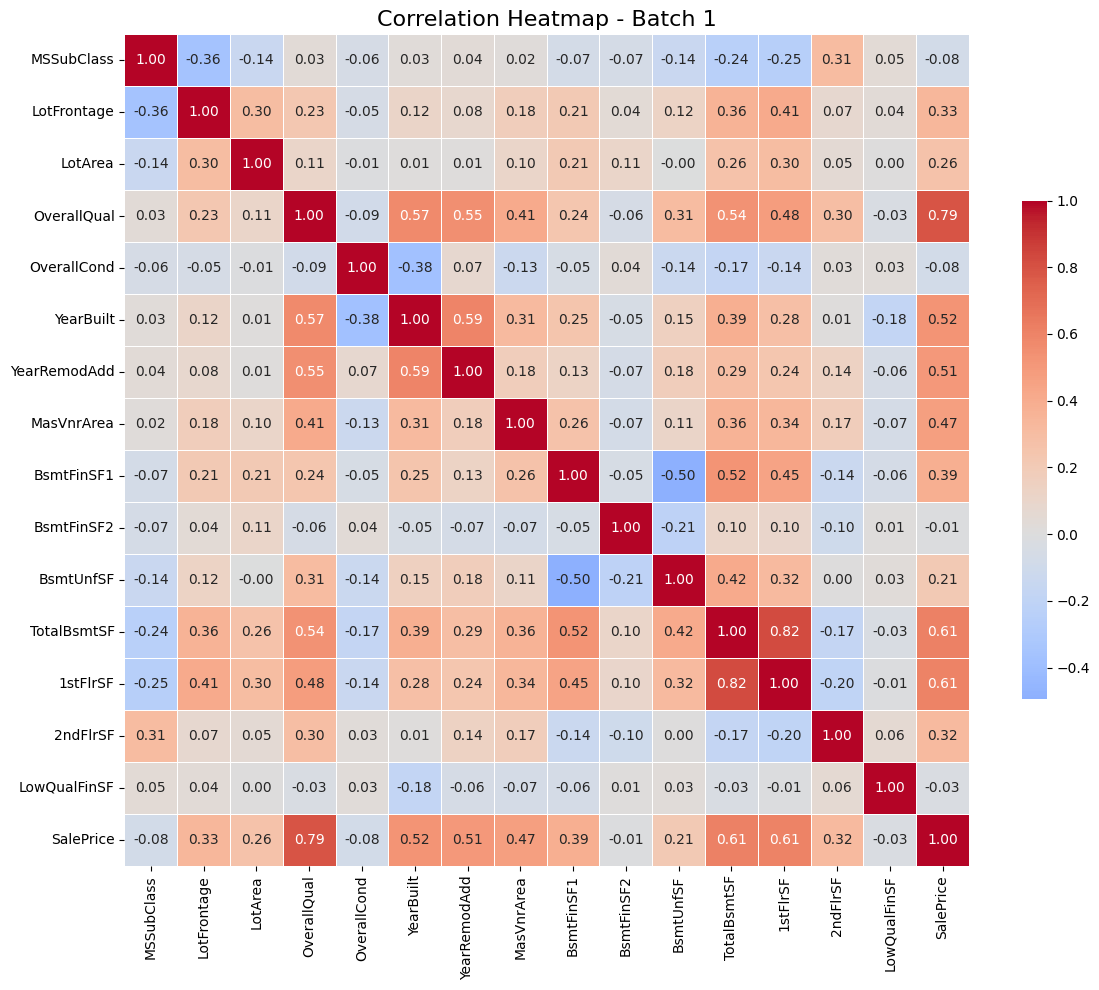

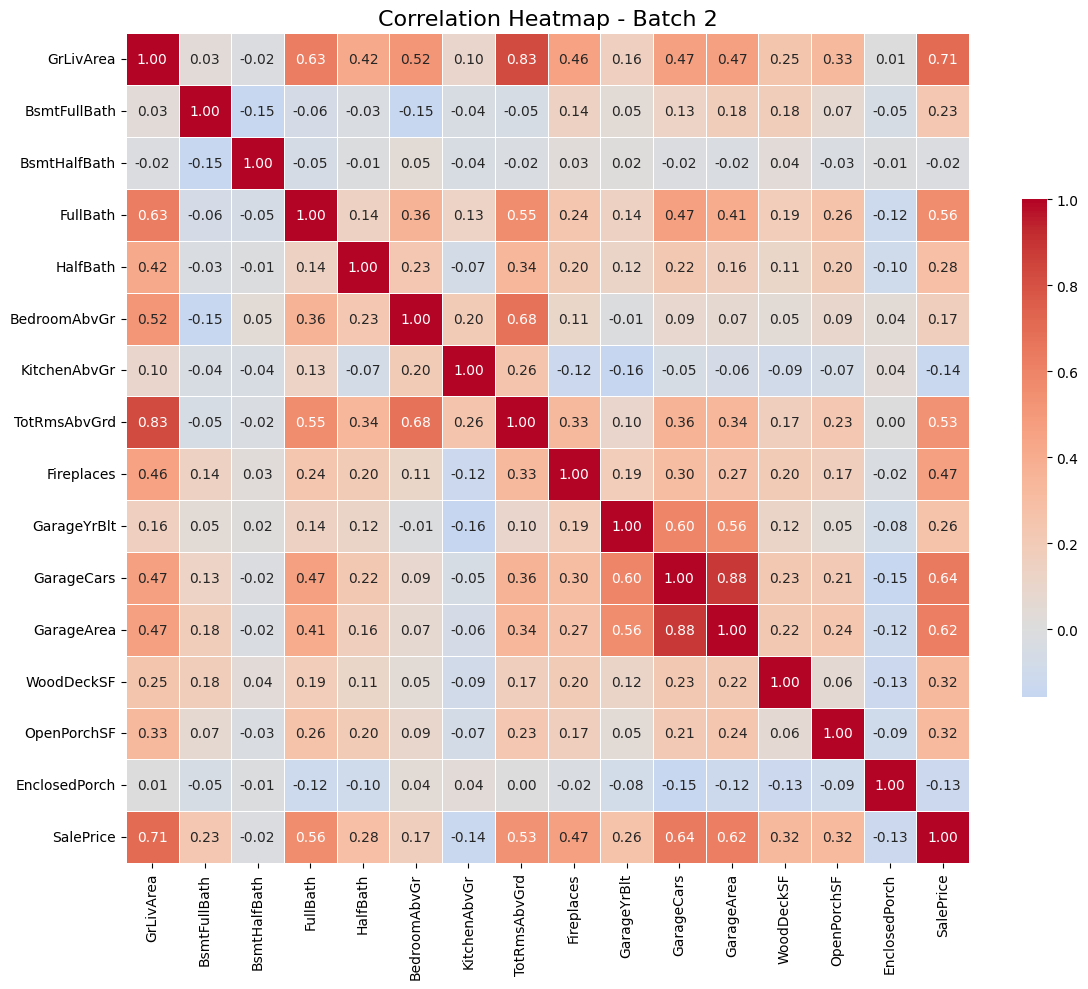

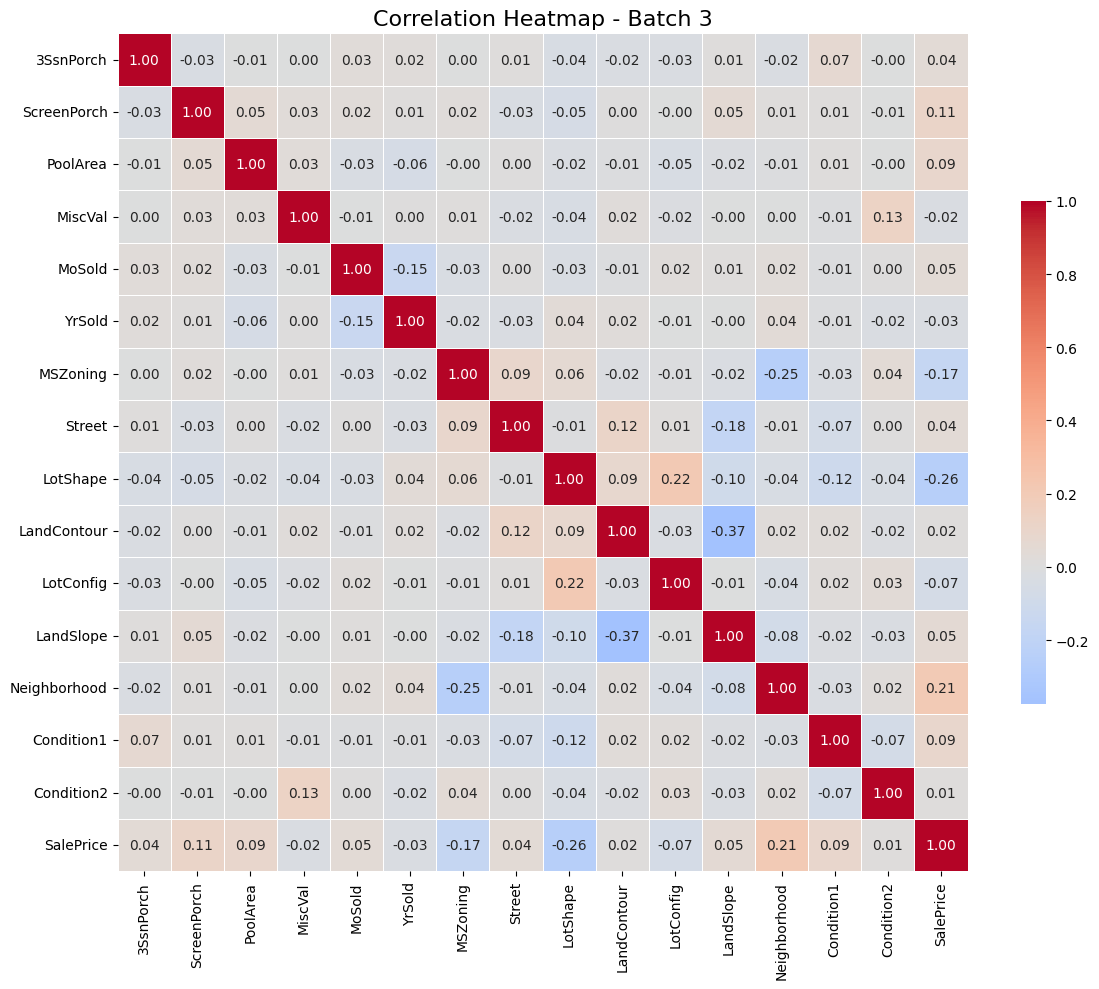

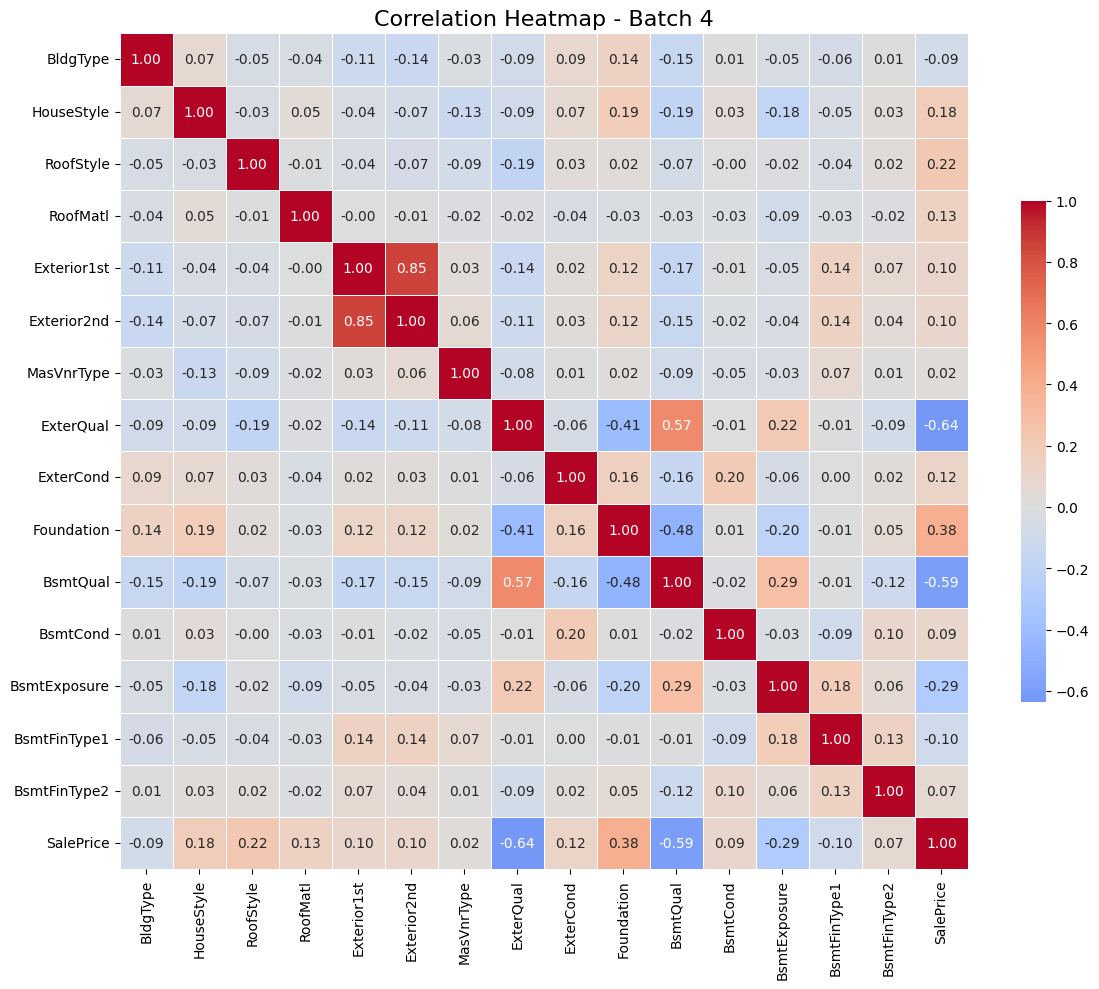

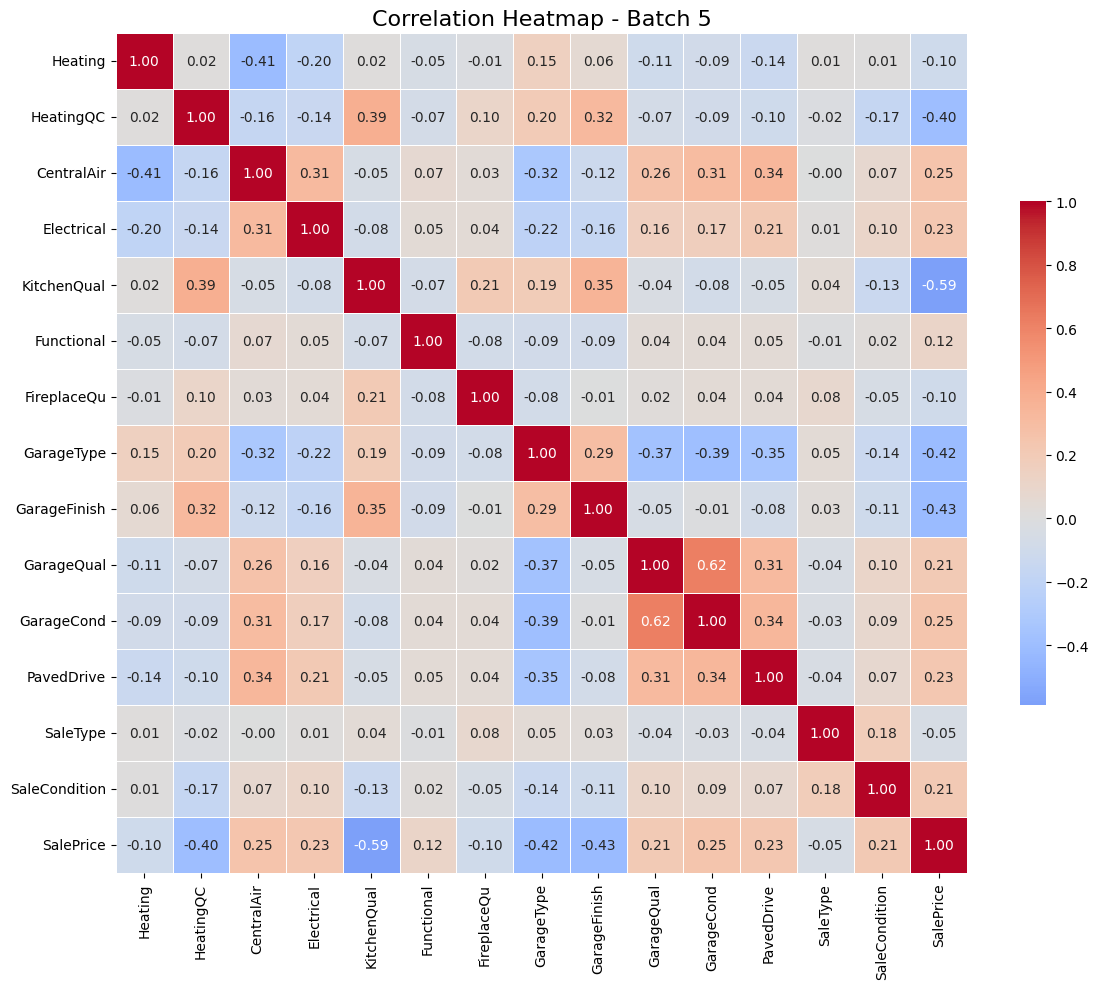

In [40]:
corr_matrix = train_transformed.corr(numeric_only=True)

features = [col for col in corr_matrix.columns if col != "SalePrice"]

batch_size = 15
feature_batches = [features[i:i + batch_size] for i in range(0, len(features), batch_size)]

for i, batch in enumerate(feature_batches, 1):
    cols_to_plot = batch + ['SalePrice']
    corr_subset = corr_matrix.loc[cols_to_plot, cols_to_plot]
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr_subset,
        cmap='coolwarm',
        annot=True,
        fmt=".2f",
        center=0,
        linewidths=0.5,
        cbar_kws={'shrink': 0.6}
    )
    plt.title(f'Correlation Heatmap - Batch {i}', fontsize=16)
    plt.tight_layout()
    plt.show()

In [41]:
# These are duplicated columns
cols_to_drop = ["Exterior2nd", "GarageCars", "TotRmsAbvGrd", "1stFlrSF","GarageYrBlt"]
train_transformed = train_transformed.drop(cols_to_drop, axis=1) 
test_transformed = test_transformed.drop(cols_to_drop, axis=1) 

train_transformed.shape, test_transformed.shape

((1460, 70), (1459, 69))

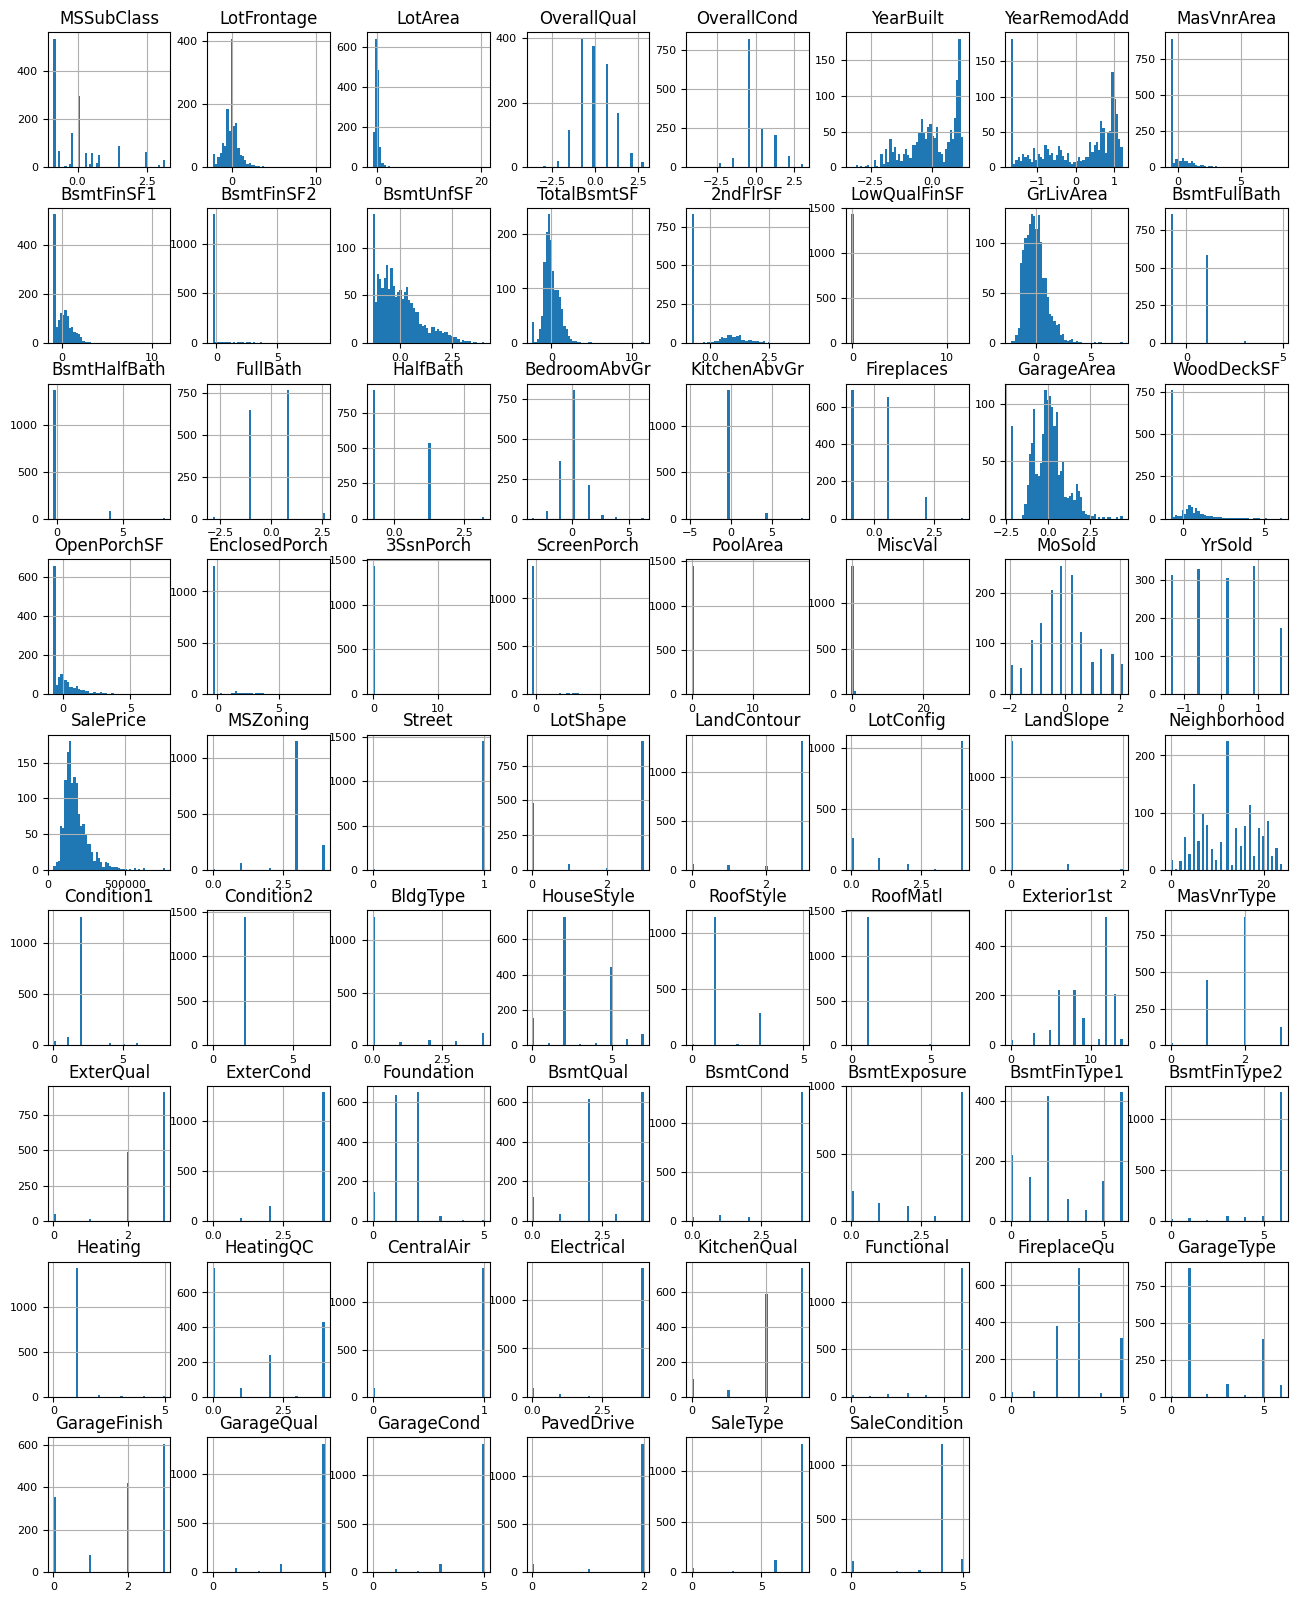

In [42]:
train_transformed.isna().sum()[train_transformed.isna().sum()>0]

test_transformed.isna().sum()[train_transformed.isna().sum()>0]

train_transformed.select_dtypes(include=['int64', 'float64']).hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

In [47]:
%pip install  lightgbm 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

X = train_transformed.drop(["SalePrice"], axis=1)
y = train_transformed["SalePrice"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

y = np.log1p(train_transformed["SalePrice"])
full = pd.concat([train_transformed.drop(columns=["SalePrice"]), test_transformed], axis=0)


X = full.iloc[:len(train_transformed)]
X_test = full.iloc[len(train_transformed):]

def rmsle_cv(model):
    kf = KFold(5, shuffle=True, random_state=42).get_n_splits(X)
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf))
    return rmse.mean()

ridge = Ridge(alpha=20)
xgb_model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=3, subsample=0.7)
lgb_model = lgb.LGBMRegressor(objective='regression', num_leaves=4, learning_rate=0.01, n_estimators=5000)
cat_model = CatBoostRegressor(iterations=500, learning_rate=0.05, depth=3, verbose=False)

ridge.fit(X, y)
xgb_model.fit(X, y)
lgb_model.fit(X, y)
cat_model.fit(X, y)

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   - -------------------------------------- 0.1/1.5 MB 2.0 MB/s eta 0:00:01
   - -------------------------------------- 0.1/1.5 MB 2.0 MB/s eta 0:00:01
   --- ------------------------------------ 0.1/1.5 MB 1.0 MB/s eta 0:00:02
   ------ --------------------------------- 0.2/1.5 MB 1.4 MB/s eta 0:00:01
   -------- ------------------------------- 0.3/1.5 MB 1.4 MB/s eta 0:00:01
   ----------- ---------------------------- 0.4/1.5 MB 1.6 MB/s eta 0:00:01
   ----------- ---------------------------- 0.4/1.5 MB 1.6 MB/s eta 0:00:01
   -------------- ------------------------- 0.5/1.5 MB 1.5 MB/s eta 0:00:01
   -------------- ------------------------- 0.5/1.5 MB 1.5 MB/s eta 0:00:01
   -------------- ------------------------- 0.5/1.5 MB 1.5 MB/s eta 0:00:01
   -------------- ------------------------- 0.5/1.5 MB 1.5 MB/s eta 0:00:01
   ----------------- ---------------------- 0.6/1.5 MB 1.2 MB/s eta 0:00:01
   ----------------


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2913
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 66
[LightGBM] [Info] Start training from score 12.024057


In [48]:
pred_ridge = ridge.predict(X_test)
pred_xgb = xgb_model.predict(X_test)
pred_lgb = lgb_model.predict(X_test)
pred_cat = cat_model.predict(X_test)
X_test

MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0      -0.872563     0.460320  0.110763    -0.795151     0.381743  -0.340077   
1      -0.872563     0.505733  0.375850    -0.071836     0.381743  -0.439440   
2       0.073375     0.187842  0.332053    -0.795151    -0.517200   0.852269   
3       0.073375     0.369494 -0.054002    -0.071836     0.381743   0.885390   
4       1.492282    -1.219961 -0.552407     1.374795    -0.517200   0.686666   
...          ...          ...       ...          ...          ...        ...   
1454    2.438219    -2.219047 -0.859988    -1.518467     1.280685  -0.041991   
1455    2.438219    -2.219047 -0.864197    -1.518467    -0.517200  -0.041991   
1456   -0.872563     4.093359  0.950423    -0.795151     1.280685  -0.373198   
1457    0.664586    -0.357114 -0.007600    -0.795151    -0.517200   0.686666   
1458    0.073375     0.187842 -0.089180     0.651479    -0.517200   0.719786   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  KitchenQual  \
0        -1.156380   -0.570750    0.053428    0.604293  ...          3.0   
1        -1.301740    0.027027    1.051363   -0.288653  ...          2.0   
2         0.636400   -0.570750    0.761852   -0.288653  ...          3.0   
3         0.636400   -0.460051    0.347326   -0.288653  ...          2.0   
4         0.345679   -0.570750   -0.396190   -0.288653  ...          2.0   
...            ...         ...         ...         ...  ...          ...   
1454     -0.720298   -0.570750   -0.973018   -0.288653  ...          3.0   
1455     -0.720298   -0.570750   -0.420316   -0.288653  ...          3.0   
1456      0.539493   -0.570750    1.711535   -0.288653  ...          3.0   
1457      0.345679   -0.570750   -0.233889   -0.288653  ...          3.0   
1458      0.442586   -0.050463    0.689474   -0.288653  ...          3.0   

      Functional  FireplaceQu  GarageType  GarageFinish  GarageQual  \
0            6.0          3.0         1.0           3.0         5.0   
1            6.0          3.0         1.0           3.0         5.0   
2            6.0          5.0         1.0           0.0         5.0   
3            6.0          2.0         1.0           0.0         5.0   
4            6.0          3.0         1.0           2.0         5.0   
...          ...          ...         ...           ...         ...   
1454         6.0          3.0         6.0           1.0         3.0   
1455         6.0          3.0         4.0           3.0         5.0   
1456         6.0          5.0         5.0           3.0         5.0   
1457         6.0          3.0         6.0           1.0         3.0   
1458         6.0          5.0         1.0           0.0         5.0   

      GarageCond  PavedDrive  SaleType  SaleCondition  
0            5.0         2.0       8.0            4.0  
1            5.0         2.0       8.0            4.0  
2            5.0         2.0       8.0            4.0  
3            5.0         2.0       8.0            4.0  
4            5.0         2.0       8.0            4.0  
...          ...         ...       ...            ...  
1454         3.0         2.0       8.0            4.0  
1455         5.0         2.0       8.0            0.0  
1456         5.0         2.0       8.0            0.0  
1457         3.0         2.0       8.0            4.0  
1458         5.0         2.0       8.0            4.0  

[1459 rows x 69 columns]

In [49]:
final_preds = (pred_ridge + pred_xgb + pred_lgb + pred_cat) / 4

final_preds = np.expm1(final_preds)
final_preds

array([124106.69053097, 154627.02257203, 180350.14424379, ...,
       161926.52831749, 119726.02322807, 225298.98640772])

In [50]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = final_preds
sub.to_csv('submission.csv', index=False)
sub.head()

Id      SalePrice
0  1461  124106.690531
1  1462  154627.022572
2  1463  180350.144244
3  1464  192079.364402
4  1465  187231.576344